<a href="https://colab.research.google.com/github/mancunian1792/causal_scene_generation/blob/master/causal_model/game_characters/GameCharacters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pyro-ppl

     |████████████████████████████████| 522kB 3.5MB/s 


In [0]:
import pyro
import pandas as pd
import numpy as np
import torch
import pyro.distributions as dist
import matplotlib.pyplot as plt


### DAG Representation

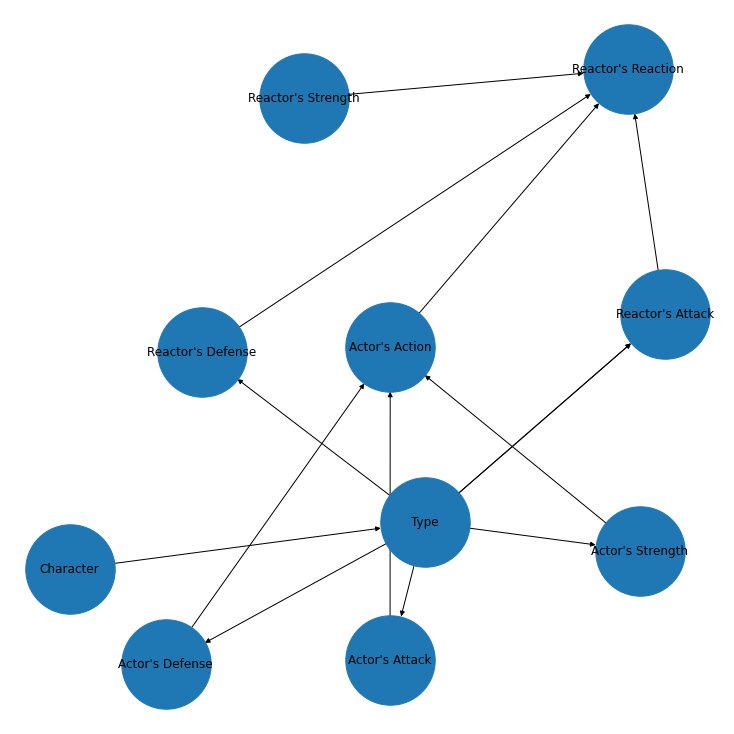

In [41]:
import networkx as nx
import matplotlib.pyplot as plt 

G = nx.MultiDiGraph()

G.add_edges_from([
    ("Character", "Type"),
    ("Type", "Actor's Strength"),
    ("Type", "Actor's Attack"),
    ("Type", "Actor's Defense"),
    ("Type", "Reactor's Defense"),
    ("Type", "Reactor's Attack"),
    ("Type", "Reactor's Attack"),
    ("Actor's Strength", "Actor's Action"),
    ("Actor's Attack", "Actor's Action"),
    ("Actor's Defense", "Actor's Action"),
    ("Reactor's Strength", "Reactor's Reaction"),
    ("Reactor's Attack", "Reactor's Reaction"),
    ("Reactor's Defense", "Reactor's Reaction"),
    ("Actor's Action", "Reactor's Reaction")
])

plt.figure(figsize=(10,10))
nx.draw(G, with_labels = True, node_size=8000)

In [0]:
values = {
      "action": ["Attacking", "Taunt", "Walking"],
      "reaction": ["Dying", "Hurt", "Idle", "Attacking"],
      "strength": ["Low", "High"],
      "defense": ["Low", "High"],
      "attack": ["Low", "High"],
      "actor": ["Satyr", "Golem"],
      "reactor": ["Satyr", "Golem"],
      "Satyr": ["satyr1", "satyr2", "satyr3"],
      "Golem": ["golem1", "golem2", "golem3"]
  }
    
cpts = {
    "action": torch.tensor([[[[0.1, 0.3, 0.6], [0.3, 0.5, 0.2]], [[0.3, 0.4, 0.4], [0.5,0.4,0.1]]],
                              [[[0.1, 0.2, 0.7], [0.4,0.3,0.3]], [[0.2, 0.4, 0.4], [0.6, 0.3, 0.1]]]]),
    
    "reaction": torch.tensor([[[[[0.5, 0.4, 0.05, 0.05], [0.2, 0.6, 0.1, 0.1], [0.001, 0.001, 0.997, 0.001]],
                    [[0.4, 0.3,0.1, 0.2], [0.1, 0.5, 0.2, 0.2], [0.001, 0.001, 0.99, 0.008]]],
                    [[[0.1, 0.3, 0.55, 0.05], [0.1, 0.2, 0.65, 0.05], [0.001, 0.001, 0.997, 0.001]],
                    [[0.3, 0.2, 0.3, 0.2],[0.1, 0.3, 0.4, 0.2],[0.001, 0.001, 0.99, 0.008]]]],
                  [[[[0.3, 0.3, 0.399, 0.001],[0.2, 0.4, 0.399, 0.001],[0.001, 0.001, 0.997, 0.001]],
                    [[0.3, 0.4, 0.1, 0.2],[0.3, 0.3, 0.1, 0.3],[0.001, 0.001, 0.99, 0.008]]],
                    [[[0.2, 0.3, 0.49, 0.01],[0.1, 0.2, 0.59, 0.01],[0.001, 0.001, 0.997, 0.001]],
                    [[0.2, 0.2, 0.4, 0.2],[0.1, 0.1, 0.4, 0.4],[0.001, 0.001, 0.99, 0.008]]]]]),
    "character": torch.tensor([0.5, 0.5]),
    "type": torch.tensor([[0.3, 0.4, 0.3], [0.4, 0.4, 0.2]]),
    "strength": torch.tensor([[[0.4, 0.6], [0.2, 0.8], [0.5, 0.5]], [[0.6, 0.4], [0.5, 0.5], [0.8, 0.2]]]),
    "defense": torch.tensor([[[0.9, 0.1], [0.3, 0.7], [0.6, 0.4]], [[0.5, 0.5], [0.4, 0.6], [0.6, 0.4]]]),
    "attack": torch.tensor([[[0.2, 0.8], [0.6, 0.4], [0.8, 0.2]], [[0.75, 0.25], [0.4, 0.6], [0.9, 0.1]]])
}

In [0]:
def condition(model, evidence, infer, val, num_samples = 1000):
        """
        Uses pyro condition function with importance sampling to get the conditional probability 
        of a particular value for the random variable under inference. 
        
        :param func model: Probabilistic model defined with pyro sample methods.
        :param dict(str, torch.tensor) evidence: Dictionary with trace objects and their observed values.
        :param str infer: Trace object which needs to be inferred.
        :param int val: Value of the trace object for which the probabilities are required.
        :param int num_samples: Number of samples to run the inference alogrithm.
        
        :return: Probability of trace object being the value provided.
        :rtype: int
        """
        
        conditioned_model = pyro.condition(model, data = evidence)
        posterior = pyro.infer.Importance(conditioned_model, num_samples=num_samples).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, infer)
        samples = np.array([marginal().item() for _ in range(num_samples)])
        
        return sum([1 for s in samples if s.item() == val])/num_samples

def intervention(model, evidence, infer, val, num_samples = 1000):
      """
      Uses pyro condition function with importance sampling to get the intervention probability 
      of a particular value for the random variable under inference.
      
      :param func model: Probabilistic model defined with pyro sample methods.
      :param dict(str, torch.tensor) evidence: Dictionary with trace objects and their observed values.
      :param str infer: Trace object which needs to be inferred.
      :param int val: Value of the trace object for which the probabilities are required.
      :param int num_samples: Number of samples to run the inference alogrithm.
      
      :return: Probability of trace object being the value provided.
      :rtype: int
      """
      
      intervention_model = pyro.do(model, data = evidence)
      posterior = pyro.infer.Importance(intervention_model, num_samples=num_samples).run()
      marginal = pyro.infer.EmpiricalMarginal(posterior, infer)
      samples = np.array([marginal().item() for _ in range(num_samples)])
      
      return sum([1 for s in samples if s.item() == val])/num_samples

In [0]:
def model():
    # To choose which is the actor (either Satyr or Golem)
    actor = pyro.sample("actor", dist.Categorical(cpts["character"]))
    reactor = pyro.sample("reactor", dist.Categorical(cpts["character"]))

    # To choose the type of Satyr or Golem (type 1, 2 or 3. This translates to different image of that character.)
    actor_type = pyro.sample("actor_type", dist.Categorical(cpts["type"][actor]))
    reactor_type = pyro.sample("reactor_type", dist.Categorical(cpts["type"][reactor]))

    # To choose the strength, defense and attack based on the character and its type. Either Low or High
    actor_strength = pyro.sample("actor_strength", dist.Categorical(cpts["strength"][actor][actor_type]))
    actor_defense = pyro.sample("actor_defense", dist.Categorical(cpts["defense"][actor][actor_type]))
    actor_attack = pyro.sample("actor_attack", dist.Categorical(cpts["attack"][actor][actor_type]))

    # To choose the character's(actor, who starts the fight) action based on the strength, defense and attack capabilities
    actor_action = pyro.sample("actor_action", dist.Categorical(cpts["action"][actor_strength][actor_defense][actor_attack]))

    # To choose the other character's strength, defense and attack based on the character and its type
    reactor_strength = pyro.sample("reactor_strength", dist.Categorical(cpts["strength"][reactor][reactor_type]))
    reactor_defense = pyro.sample("reactor_defense", dist.Categorical(cpts["defense"][reactor][reactor_type]))
    reactor_attack = pyro.sample("reactor_attack", dist.Categorical(cpts["attack"][reactor][reactor_type]))

    # To choose the character's (reactor, who reacts to the actor's action in a duel) reaction based on its own strength, defense , attack and the other character's action.
    reactor_reaction = pyro.sample("reactor_reaction", dist.Categorical(cpts["reaction"][reactor_strength][reactor_defense][reactor_attack][actor_action]))

    return  {
        "actor": actor,
        "reactor": reactor,
        "actor_type": actor_type,
        "reactor_type": reactor_type,
        "actor_strength": actor_strength,
        "actor_defense": actor_defense,
        "actor_attack": actor_attack,
        "actor_action": actor_action,
        "reactor_strength": reactor_strength,
        "reactor_defense": reactor_defense,
        "reactor_attack": reactor_attack,
        "reactor_reaction": reactor_reaction,
        }

In [0]:
def interpret_sampled_values(sample):
  infer = {}
  for key in sample.keys():
    if "_" in key:
      character, split = key.split("_")
      if split != "type":
        infer[key] = values[split][sample[key]]
      else:
        chosen_char = sample[character]
        infer[key] = values[values[character][chosen_char]][sample[key]]
    else:
      infer[key] = values[key][sample[key]]
  return infer

In [0]:
interpret_sampled_values(model())

{'actor': 'Golem',
 'actor_action': 'Walking',
 'actor_attack': 'Low',
 'actor_defense': 'High',
 'actor_strength': 'High',
 'actor_type': 'golem1',
 'reactor': 'Satyr',
 'reactor_attack': 'Low',
 'reactor_defense': 'High',
 'reactor_reaction': 'Idle',
 'reactor_strength': 'High',
 'reactor_type': 'satyr2'}

### Running a sample conditioned statement given some evidence. To check everything is in order

### Evidence : Actor is Satyr, Reactor is Golem. Actor strength is low.

### Infer: Probability of reactors reaction being Hurt

In [0]:
condition(model, {"actor": torch.tensor(0), "reactor": torch.tensor(1), "actor_strength": torch.tensor(0)}, infer="reactor_reaction", val= values["reactions"].index("Hurt"))

0.238

### Trying to convert the above into a SCM

In [0]:
def gmax(u, p):
  gumbell = -torch.log(-torch.log(u)) + torch.log(p)
  return max(range(u.shape[0]), key = lambda i: gumbell[i])

def cat_delta(i, size):
  """ Create a categorical with prob mass all on one point
  This will allow us to bind a variable to the trace despite
  being deterministically calculated given the parent.  
  """
  p = torch.zeros(size)
  p[i] = torch.tensor(1.0)
  return dist.Categorical(p)
def f_x(u):
  # -> What is this probability ? Probability of choosing that category ?
  # -> How would it be if i have a dependent variable. If i am going to anyway have the conditional
  # -> Probability tables (given the dependent variable) what's the use of gumbel max ? 
  p = torch.tensor([0.5410, 0.2026, 0.2563]) 
  x = pyro.sample('x', cat_delta(gmax(u, p), p.shape[0]))
  return x 
def scm_model():
  u_x = dist.Uniform(torch.zeros(3), torch.ones(3)).sample()
  x = f_x(u_x)
  return x
